 # Problem
1. The raw event types are numerous and sometimes contain dynamic values (e.g., IDs, file paths).

2. Many events are semantically similar but have different names.

3. We want to unify them into stable categories, e.g., "Command", "ControllerConnection", "UI.TabChange".

#  Normalization Approach
1. We define a set of rules that map specific patterns of event_type (and occasionally parameters) to normalized labels.

# Find popular event sequence
1. n-grams
2. markov chain + graph

In [ ]:
import os
import re
import pandas as pd
from collections import Counter
from itertools import islice
from mlxtend.frequent_patterns import apriori, association_rules
from google.colab import drive

# load Google Drive
drive.mount("/content/drive", force_remount=True)

# load deleted_features.txt as delete /d_features

# Sample logs (same as user provided)
log_lines = [
    "00:00:36.8147456|ControllerConnectionState|{D36779C8-DDC9-4295-A0D9-BC3B0A096645}|1",
    "00:00:37.1937165|AddedController|{D36779C8-DDC9-4295-A0D9-BC3B0A096645}|VC|7.12.0.0",
    "00:00:43.8096871|ActiveWindowChanged|DelayLoadedWindow|ControllerBrowser",
    "00:00:56.8694018|ExecutingCommand|TextEditorShow|Activated",
    "00:00:57.7101821|ActiveWindowChanged|GenericControllerFileItemTextEditorWindow|NoId",
    "00:00:58.1290534|ExecutedCommand|TextEditorShow",
    "00:01:02.0301210|ActiveWindowChanged|DelayLoadedWindow|ControllerBrowser",
]

def parse1_log_file(events):
    """ parse log file, return event sequence """
    event_sequence = []

    for line in events.strip().split("\n"):
        parts = line.split("|")

        if len(parts) >= 3:
            timestamp, event_type, details = parts[0], parts[1], parts[2]
            # delete GUID and *.sab
            # AddedController, {29482355-91EB-4976-A615-0901346C9494}
            # Error, PIM: Could not load stream Streams/fcd2a5adad94440e945437b369b280e5.GeoDataStream.sab
            details = re.sub('/[^ ]+\\.sab', '',details)
            details = re.sub(r'\{[A-Za-z0-9-]+\}', '', details)
            # Use regex to find and remove numeric strings longer than 6 characters
            details = re.sub(r'\b\d{3,}\b', '', details)
            # Use regex to find and remove file path
            details = re.sub(r"[A-Za-z]:\\[^ ]+", '', details)
            if event_type == 'Exception':
                details = ""
            event_sequence.append(event_type)

    return event_sequence


def parse2_log_file(events):
    """ parse log file, return event sequence """
    event_sequence = []

    for line in events.strip().split("\n"):
            parts = line.split("｜")

            if len(parts) >= 3:
                timestamp, event_type, details = parts[0], parts[1], parts[2]
                # delete GUID and *.sab
                # AddedController, {29482355-91EB-4976-A615-0901346C9494}
                # Error, PIM: Could not load stream Streams/fcd2a5adad94440e945437b369b280e5.GeoDataStream.sab
                details = re.sub('/[^ ]+\\.sab', '',details)
                details = re.sub(r'\{[A-Za-z0-9-]+\}', '', details)
                # Use regex to find and remove numeric strings longer than 6 characters
                details = re.sub(r'\b\d{3,}\b', '', details)
                # Use regex to find and remove file path
                details = re.sub(r"[A-Za-z]:\\[^ ]+", '', details)
                if event_type == 'Exception':
                    details = ""
                event_sequence.append(event_type+','+details)

    return event_sequence



def generate_ngrams(sequence, n):
    return list(zip(*[islice(sequence, i, None) for i in range(n)]))

def analyze_common_sequences(file_path,parsetype=1, n_gram_size=2, min_support=0.5):

    # Iterate through each file
    data = pd.read_csv(file_path)
    embedding_input = pd.DataFrame(columns=["file", "parsed_events"])
    all_sequences = []
    for filename, events in data[['file','events']].values:

        # Parse the log events
        if parsetype==1:
          event_sequence = parse1_log_file(events)
        else:
          event_sequence = normalize_events(events)


        all_sequences.append(event_sequence)


    # generate N-gram
    all_ngrams = [generate_ngrams(seq, n_gram_size) for seq in all_sequences]

    # calculate frequency
    flattened_ngrams = [item for sublist in all_ngrams for item in sublist]
    ngram_counts = Counter(flattened_ngrams)

    # filte low frequency gram out
    ngram_df = pd.DataFrame(ngram_counts.items(), columns=[f"{n_gram_size}-gram", "Count"])
    ngram_df = ngram_df.sort_values(by="Count", ascending=False)

    # transfer N-gram into Apriori needed（one-hot code）
    unique_ngrams = list(set(flattened_ngrams))

    transactions = []
    for ngram_list in all_ngrams:
        transaction = {ngram: (ngram in ngram_list) for ngram in unique_ngrams}
        transactions.append(transaction)

    df_transactions = pd.DataFrame(transactions)

    # run Apriori
    freq_items = apriori(df_transactions, min_support=min_support, use_colnames=True)

    print("🔍 popular sequence:")
    print(freq_items.sort_values(by="support", ascending=False))

    return ngram_df, freq_items




Mounted at /content/drive


In [ ]:
# file_path = '/content/drive/MyDrive/data/sample_1_logs.csv'
file_path = '/content/drive/MyDrive/data/select_premium0702.csv'
ngram_results, frequent_patterns = analyze_common_sequences(file_path,parsetype=1, n_gram_size=3, min_support=0.6)


🔍 popular sequence:
    support                                           itemsets
0  0.920526        ((AddinLoading, AddinLoaded, AddinLoading))
2  0.819325         ((AddinLoaded, AddinLoading, AddinLoaded))
5  0.815323  ((AddinLoading, AddinLoaded, AddinLoading), (A...
1  0.671241             ((AddinAdded, AddinAdded, AddinAdded))
4  0.622642  ((AddinLoading, AddinLoaded, AddinLoading), (A...
3  0.608919       ((AddinAdded, AddinAdded, UIThreadWatchdog))


In [ ]:
# Rebuild the normalization rule table exactly as before (from previous rule definitions)
normalization_rules = [
    ("ExecutedCommand, X ", "ExecutedCommand:X", "All command executions initiated by the user is executed."),
    ("ExecutingCommand, X", "ExecutingCommand:X", "All command executions initiated by the user is executing."),
    ("ControllerConnectionState, {UUID}", "ControllerConnectionState", "Controller connected or disconnected."),
    ("AddinLoaded / AddinAdded / AddinLoading", "Addin:X", "Loaded or added RobotStudio add-ins."),
    ("NetworkAdapterChange, <Adapter>", "NetworkAdapterChange", "Network adapter state change."),
    ("ImportedMechanism, <ModelName>", "ImportedMechanism", "Imported robot or tool mechanisms."),
    ("ActiveWindowChanged, <Window>", "ActiveWindowChanged", "Change in active UI window."),
    ("RibbonTabChanged, <Tab>", "RibbonTabChanged", "Switch between top ribbon tabs."),
    ("InstallDistributionPackage, <Package>", "InstallDistributionPackage", "Installed RobotStudio extensions."),
    ("StartedVC / StartingVC / VCAffinity", "VirtualControllerEvent", "Events related to Virtual Controller startup."),
    ("Error, <Message>", "Error", "System or plugin error logs."),
    ("SystemEvent, <Event>", "SystemEvent", "System-level event like suspend/resume."),
    ("UserLogMessage, <Message>", "UserLogMessage", "User-visible logs or warnings."),
    ("UIThreadWatchdog, ...", "UIThreadWatchdog", "UI thread performance alerts."),
    ("ApiInfo, <Detail>", "ApiInfo", "Messages from API or plugin status."),
    ("ControllerState, ...", "ControllerState", "State changes in robot controller."),
    ("StudioAppFramework, ...", "StudioAppFramework", "Warnings or errors in RobotStudio’s GUI framework."),
    ("RobApiSubscribeError, ...", "RobApiSubscribeError", "Robot API subscription failure."),
    ("Exception, ...", "Exception", "Unhandled exceptions or crashes."),
    ("VR, ...", "VR", "Virtual Reality interaction logs."),
    ("PaintApplicator, ...", "PaintApplicator", "Warnings related to paint or spray tools."),
    ("ExportGeometry, ...", "ExportGeometry", "Exporting CAD or geometry data."),
    ("ImportingCADFile, <Type>", "ImportingCADFile", "Importing files from external CAD tools."),
    ("StationLoaded, <ID>", "StationLoaded", "RobotStudio station/project loaded."),
    ("ActivatedPP, <PowerPac>", "ActivatedPP", "PowerPac activated (e.g. ArcWeld, Picking)."),
]

"""
00:00:10.6720537|GraphicsFeatureLevel|D3D_FEATURE_LEVEL_11_0
00:00:11.8284027|UIThreadWatchdog|Warning|2000 ms delay on UI thread
00:00:12.4845839|AddinLoading|ScreenShotAddin
00:00:12.5002497|BackstageVisibilityChanged|False
00:00:12.7345922|RibbonTabChanged|Automation
00:00:12.7502166|AddinLoaded|ScreenShotAddin
00:00:12.7970930|RibbonTabChanged|Home
00:00:13.5784128|StationCreated
00:00:13.8439816|UIThreadWatchdog|Warning|4000 ms delay on UI thread
00:00:13.8439816|ActiveWindowChanged|GraphicWindow|NoId
00:00:57.4072189|ExecutingCommand|LibGalleryABB|Activated
00:00:58.2822343|ImportedMechanism|IRB6700_235_265
00:00:58.2822343|ExecutedCommand|LibGalleryABB
00:01:02.3917263|ExecutingCommand|LibGalleryABB|Activated
00:01:02.9541861|ImportedMechanism|IRB7600_150_350
00:01:02.9541861|ExecutedCommand|LibGalleryABB
00:01:10.0793071|ExecutingCommand|LibGalleryABB|Activated
00:01:10.1886793|ImportingCADFile|RSGFX|124713
00:01:10.3918098|ImportingCADFile|RSGFX|77844
"""

# Normalization function based on rule table
# make it fater
def normalize_from_rule(event_type, args):
    if event_type in ["ExecutingCommand", "ExecutedCommand"]:
        return "Command:" + args
    elif event_type == "ControllerConnectionState":
        return "ControllerConnectionState"
    elif event_type == "AddinLoaded" or event_type == "AddinAdded" or event_type == "AddinLoading":
        return "Addin:" + args
    elif event_type == "NetworkAdapterChange":
        return "NetworkAdapterChange"
    elif event_type == "ImportedMechanism":
        return "ImportedMechanism"
    elif event_type == "ActiveWindowChanged":
        return "ActiveWindowChanged"
    elif event_type == "RibbonTabChanged":
        return "RibbonTabChanged"
    elif event_type == "InstallDistributionPackage":
        return "InstallDistributionPackage"
    elif event_type in ["StartedVC", "StartingVC", "VCAffinity"]:
        return "VirtualControllerEvent"
    elif event_type == "Error":
        return "Error"
    elif event_type == "SystemEvent":
        return "SystemEvent"
    elif event_type == "UserLogMessage":
        return "UserLogMessage"
    elif event_type == "UIThreadWatchdog":
        return "UIThreadWatchdog"
    elif event_type == "ApiInfo":
        return "ApiInfo"
    elif event_type == "ControllerState":
        return "ControllerState"
    elif event_type == "StudioAppFramework":
        return "StudioAppFramework"
    elif event_type == "RobApiSubscribeError":
        return "RobApiSubscribeError"
    elif event_type == "Exception":
        return "Exception"
    elif event_type == "VR":
        return "VR"
    elif event_type == "PaintApplicator":
        return "PaintApplicator"
    elif event_type == "ExportGeometry":
        return "ExportGeometry"
    elif event_type == "ImportingCADFile":
        return "ImportingCADFile"
    elif event_type == "StationLoaded":
        return "StationLoaded"
    elif event_type == "ActivatedPP":
        return "ActivatedPP"
    else:
        return event_type

# Parse, normalize and format output
def normalize_events(events):
    event_sequence = []

    for line in events.strip().split("\n"):
        parts = line.split("|")
        if len(parts) >= 3:
            timestamp, event_type, details = parts[0], parts[1], parts[2]
            # delete GUID and *.sab
            # AddedController, {29482355-91EB-4976-A615-0901346C9494}
            # Error, PIM: Could not load stream Streams/fcd2a5adad94440e945437b369b280e5.GeoDataStream.sab
            details = re.sub('/[^ ]+\\.sab', '',details)
            details = re.sub(r'\{[A-Za-z0-9-]+\}', '', details)
            # Use regex to find and remove numeric strings longer than 6 characters
            details = re.sub(r'\b\d{3,}\b', '', details)
            # Use regex to find and remove file path
            details = re.sub(r"[A-Za-z]:\\[^ ]+", '', details)
            if event_type == 'Exception':
                details = ""
            event_sequence.append( normalize_from_rule(event_type, details))

    return event_sequence




In [ ]:
# Convert to DataFrame
rules_df = pd.DataFrame(normalization_rules, columns=["Original Pattern", "Normalized Label", "Description"])

print(rules_df)
print(rules_df)
#command importedmanchanism exportgeometry VR activewindowchanged RibbonTabchanged
#ActiveWindowChanged|DelayLoadedWindow|ControllerBrowser chooae the forth one
#

                           Original Pattern            Normalized Label  \
0                       ExecutedCommand, X            ExecutedCommand:X   
1                       ExecutingCommand, X          ExecutingCommand:X   
2         ControllerConnectionState, {UUID}   ControllerConnectionState   
3   AddinLoaded / AddinAdded / AddinLoading                     Addin:X   
4           NetworkAdapterChange, <Adapter>        NetworkAdapterChange   
5            ImportedMechanism, <ModelName>           ImportedMechanism   
6             ActiveWindowChanged, <Window>         ActiveWindowChanged   
7                   RibbonTabChanged, <Tab>            RibbonTabChanged   
8     InstallDistributionPackage, <Package>  InstallDistributionPackage   
9       StartedVC / StartingVC / VCAffinity      VirtualControllerEvent   
10                         Error, <Message>                       Error   
11                     SystemEvent, <Event>                 SystemEvent   
12                UserLog

In [ ]:
file_path = '/content/drive/MyDrive/data/select_premium0702.csv'
ngram_results, frequent_patterns = analyze_common_sequences(file_path,2, n_gram_size=3, min_support=0.6)

KeyboardInterrupt: 

) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


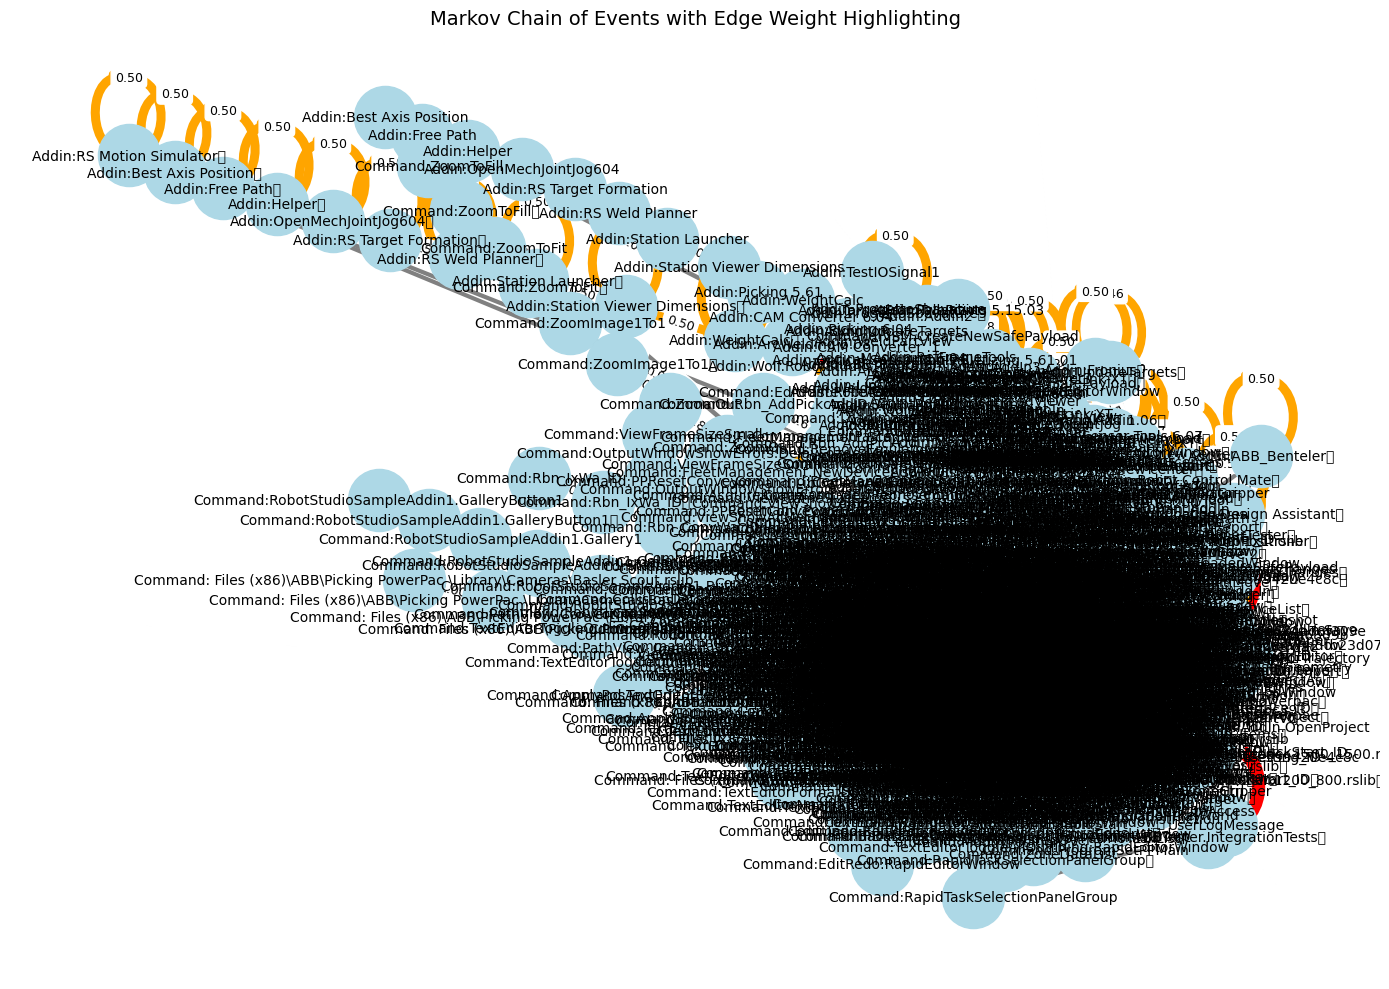

dict_keys(['Addin:Picking', 'Addin:PickMaster PowerPac', 'UserLogMessage', 'Addin:Equipment Builder', 'Addin:RobotLoad', 'UIThreadWatchdog', 'Addin:Lincoln ArcLink-XT', 'Addin:Visual SafeMove 2\r', 'Addin:MeshModeling\r', 'Addin:FleetAssessment\r', 'Addin:I/O Engineering\r', 'Addin:LincolnArcLink-XT 1.06\r', 'Addin:Fronius TPSi-Add-in\r', 'Addin:3DP .5\r', 'NetworkAdapterChange', 'Addin:FroniusTPSi-Add-in\r', 'User', 'Exception', 'Addin:Fronius TPSi\r', 'Addin:Abb.Rcmp.AddIn\r', 'BackstageVisibilityChanged', 'ControllerConnectionState', 'ActiveWindowChanged', 'ImportedMechanism', 'Addin:MultiMove\r', 'VirtualControllerEvent', 'Addin:3D Printing\r', 'RibbonTabChanged', 'Command:FileOpen', 'Command:Options', 'Addin:UpdateTargets\r', 'SystemEvent', 'ApiInfo', 'Addin:Equipment Builder\r', 'Addin:External Axis Wizard\r', 'Addin:Lincoln ArcLink-XT\r', 'Command:FileSave', 'Error', 'Addin:VisibilityTools\r', 'Command:OutputWindowClear:DelayLoadedWindow', "Addin:Puime's Addin\r", 'Command:Virtu

In [ ]:
import os
import re
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

# Simulated multiple log files
log_files = {
    "log1.rslog": """
        00:00:00.6398703|User|SignedOut
        00:00:01.3101292|AddinAdded|Palletizing|PowerPac
        00:00:02.7730444|UIThreadWatchdog|Started
        00:00:12.4080118|RibbonTabChanged|Controller
        00:00:25.0331169|StationLoading
        00:00:25.3157550|StationLoaded|3645313
        00:00:54.1686503|ExecutingCommand|LaunchVNext|Activated
        00:00:56.4821445|ExecutedCommand|LaunchVNext
    """,
    "log2.rslog": """
        01:13:10.8245843|ExecutingCommand|ConnectController|Activated
        01:13:22.2865161|ExecutedCommand|ConnectController
        01:13:22.3460775|VCAffinity|2
        01:13:29.3981175|ControllerConnectionState|{ID}|1
        01:13:29.4211031|AddedController|{ID}|VC|7.15.0.0
        01:13:37.7409318|ActiveWindowChanged|ControllerBrowser
        01:13:50.0115659|ExecutingCommand|OnlineMonitor|Activated
        01:13:50.0830779|ExecutedCommand|OnlineMonitor
    """
}

# Regex to extract the event type (second field)
data = pd.read_csv(file_path)

# Step 1: Extract event sequences from all log files
all_event_sequences = []
for events in data['events'].values:
    all_event_sequences.append(normalize_events(events))

# Step 2: Count event transitions
transition_counts = defaultdict(lambda: defaultdict(int))
for seq in all_event_sequences:
    for a, b in zip(seq, seq[1:]):
        transition_counts[a][b] += 1

# Step 3: Compute transition probabilities
transition_probs = {
    from_event: {
        to_event: count / sum(targets.values())
        for to_event, count in targets.items()
    }
    for from_event, targets in transition_counts.items()
}

# Step 4: Build a weighted directed graph with edge thickness and color for frequency
G = nx.DiGraph()
for from_event, targets in transition_probs.items():
    for to_event, prob in targets.items():
        G.add_edge(from_event, to_event, weight=prob)

# Step 5: Define edge colors and widths based on weights
edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
max_weight = max(weights)
edge_colors = ['red' if w > 0.6 else 'orange' if w > 0.3 else 'gray' for w in weights]
edge_widths = [3 + 7 * (w / max_weight) for w in weights]

# Step 6: Draw the full graph
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue')
nx.draw_networkx_labels(G, pos, font_size=10)
nx.draw_networkx_edges(G, pos, edgelist=edges, width=edge_widths, edge_color=edge_colors, arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}, font_size=9)

plt.title("Markov Chain of Events with Edge Weight Highlighting", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

# Step 7: Separate subgraphs by event category (prefix)
# Categories: ExecutingCommand, User, AddinAdded, etc.
event_categories = defaultdict(set)
for event in G.nodes():
    prefix = event.split("|")[0] if "|" in event else event
    event_categories[prefix].add(event)

# Step 8: Create a subgraph for each category
category_subgraphs = {}
for category, nodes in event_categories.items():
    subgraph = G.subgraph(nodes).copy()
    if subgraph.number_of_edges() > 0:
        category_subgraphs[category] = subgraph

category_subgraphs.keys()  # Display available categories for visualization


In [ ]:
# Regex to extract the event type (second field)
data = pd.read_csv(file_path)

# Step 1: Extract event sequences from all log files
all_event_sequences = []
for events in data['events'].values:
    all_event_sequences.append(normalize_events(events))

# Step 2: Count event transitions
transition_counts = defaultdict(lambda: defaultdict(int))
for seq in all_event_sequences:
    for a, b in zip(seq, seq[1:]):
        transition_counts[a][b] += 1

# Step 3: Compute transition probabilities
transition_probs = {
    from_event: {
        to_event: count / sum(targets.values())
        for to_event, count in targets.items()
    }
    for from_event, targets in transition_counts.items()
}

# Step 4: Build a weighted directed graph with edge thickness and color for frequency
G = nx.DiGraph()
for from_event, targets in transition_probs.items():
    for to_event, prob in targets.items():
      G.add_edge(from_event, to_event, weight=prob)

In [ ]:
print(transition_probs)

{'Addin:I/O Engineering': {'Addin:Visual SafeMove 2': 1.0}, 'Addin:Visual SafeMove 2': {'UIThreadWatchdog': 1.0}, 'UIThreadWatchdog': {'BackstageVisibilityChanged': 0.3333333333333333, 'Addin:I/O Engineering\r': 0.6666666666666666}, 'BackstageVisibilityChanged': {'RibbonTabChanged': 1.0}, 'RibbonTabChanged': {'UIThreadWatchdog': 1.0}, 'Addin:I/O Engineering\r': {'UIThreadWatchdog': 0.5, 'Addin:Visual SafeMove 2\r': 0.5}, 'Addin:Visual SafeMove 2\r': {'Addin:Visual SafeMove 2\r': 0.5, 'UIThreadWatchdog': 0.5}}


In [ ]:
from pyvis.network import Network
import networkx as nx
from IPython.core.display import display, HTML

# 构建子图（例如只包含以 Command 开头的事件）
prefix = "Command"
nodes_to_include = [n for n in G.nodes if n.startswith(prefix)]
subG = G.subgraph(nodes_to_include).copy()

# 创建 pyvis 网络图
net = Network(height="750px", width="100%", directed=True, notebook=True, cdn_resources="in_line")

# 添加节点和边（鼠标悬停显示名字）
for node in subG.nodes():
    net.add_node(node, label="", title=node)

for u, v, data in subG.edges(data=True):
    net.add_edge(u, v, value=data['weight'])

# 生成 HTML 文件
net.save_graph("command_subgraph.html")

# 在 Colab / Jupyter 中内嵌显示图
with open("command_subgraph.html", "r", encoding="utf-8") as f:
    html_content = f.read()

display(HTML(html_content))

In [ ]:
current_event = "ExecutingCommand"
workflow = [current_event]

while current_event in transition_probs:
    next_events = transition_probs[current_event]
    if not next_events:
        break
    # 按概率排序，选出概率最高的下一个事件
    next_event = max(next_events.items(), key=lambda x: x[1])[0]
    workflow.append(next_event)
    current_event = next_event

In [ ]:
def generate_workflow(start_event, transition_probs, max_steps=10, min_prob=0.01):
    """
    Generate a most-likely event workflow path from a starting event using Markov Chain transitions.

    Args:
        start_event (str): The event to start from.
        transition_probs (dict): Dictionary of transition probabilities between events.
        max_steps (int): Maximum number of steps in the workflow.
        min_prob (float): Minimum probability threshold to continue.

    Returns:
        list: A sequence of events forming a likely workflow path.
    """
    path = [start_event]          # Initialize path with the start event
    current = start_event         # Start from the given event

    for _ in range(max_steps):
        next_events = transition_probs.get(current, {})
        if not next_events:
            break  # No outgoing transitions, stop

        # Choose the most probable next event
        next_event, prob = max(next_events.items(), key=lambda x: x[1])
        if prob < min_prob:
            break  # Next transition is too uncertain

        path.append(next_event)
        current = next_event

    return path

def to_mermaid_flow(path):
    """
    Convert a list of events into Mermaid flowchart syntax.

    Args:
        path (list): Event sequence.

    Returns:
        str: Mermaid graph definition.
    """
    return "\n".join([f"{a} --> {b}" for a, b in zip(path, path[1:])])

In [ ]:
workflow = generate_workflow("ExecutingCommand", transition_probs, max_steps=10)
print(" → ".join(workflow))
print("\nMermaid Format:\n")
print(to_mermaid_flow(workflow))

In [ ]:
def to_mermaid_flow(path):
    return "\n".join([f"{a} --> {b}" for a, b in zip(path, path[1:])])
print(to_mermaid_flow(workflow))

In [ ]:
def filter_transitions_for_command_execution(transition_probs):
    """
    Filters the transition probability dictionary to only include transitions
    where both the source and the target start with 'ExecutingCommand' or 'ExecutedCommand'.

    Args:
        transition_probs (dict): The full transition probability matrix (Markov Chain).

    Returns:
        dict: A filtered transition_probs dictionary with only the desired event types.
    """
    allowed_prefixes = ('ExecutingCommand', 'ExecutedCommand')
    filtered = {}

    for from_event, targets in transition_probs.items():
        if not from_event.startswith(allowed_prefixes):
            continue  # Skip this source event

        # Filter targets that match the prefix rule
        filtered_targets = {
            to_event: prob
            for to_event, prob in targets.items()
            if to_event.startswith(allowed_prefixes)
        }

        if filtered_targets:
            filtered[from_event] = filtered_targets

    return filtered

In [ ]:
filtered_probs = filter_transitions_for_command_execution(transition_probs)

workflow = generate_workflow("ExecutingCommand:ConnectController", filtered_probs)
print(" → ".join(workflow))